In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-may-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2021/train.csv
/kaggle/input/tabular-playground-series-may-2021/test.csv


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

In [3]:
train = pd.read_csv("/kaggle/input/tabular-playground-series-may-2021/train.csv")
test = pd.read_csv("/kaggle/input/tabular-playground-series-may-2021/test.csv")
display(train.head())
display(test.head())

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,...,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Class_2


,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,100000,0,0,0,0,0,0,4,4,0,...,0,0,0,0,0,0,0,0,0,0
1,100001,0,0,1,0,0,0,2,0,7,...,3,0,1,0,0,0,1,0,2,1
2,100002,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,6,0
3,100003,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,6,9,14,3
4,100004,0,0,0,0,0,0,1,0,4,...,1,0,0,0,0,0,0,0,0,0


In [4]:
train.isnull().sum()

id            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
target        0
dtype: int64

In [5]:
train.target.value_counts()

Class_2    57497
Class_3    21420
Class_4    12593
Class_1     8490
Name: target, dtype: int64

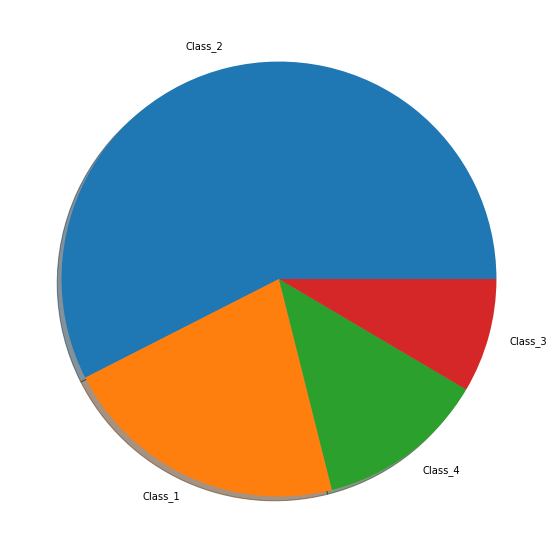

In [6]:
fig = plt.figure(figsize=(10,10))
plt.pie(train.target.value_counts(), labels=train.target.unique(), shadow=True)

plt.show()

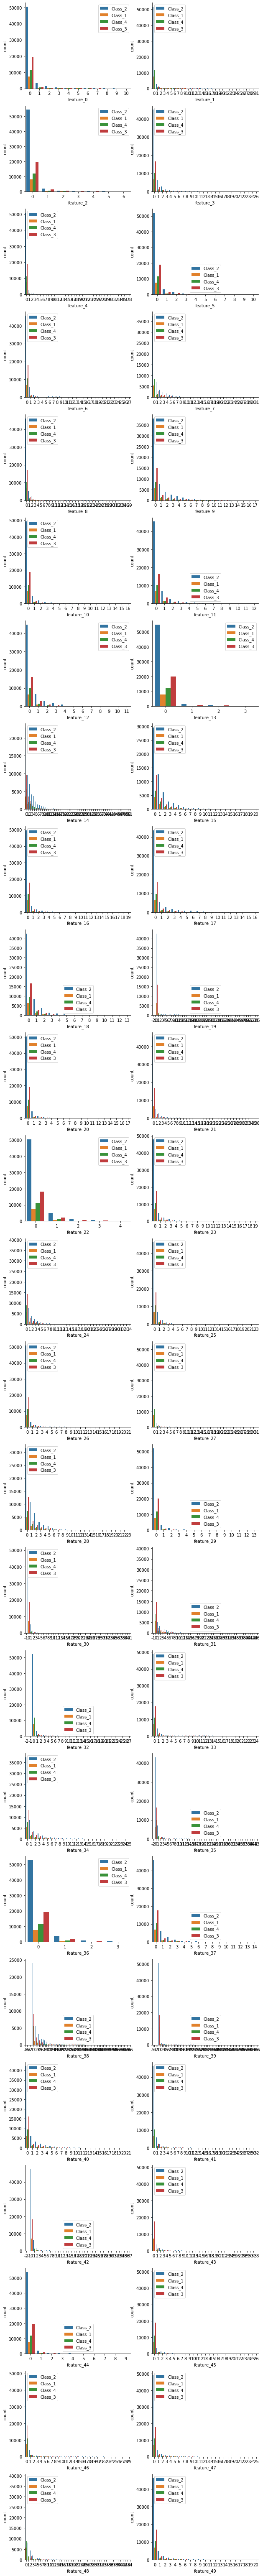

In [7]:
features = [col for col in train.columns if col not in ['id', 'target']]
size = (10, (len(features)//2) * 4.5)

plt.subplots(len(features)//2, 2, figsize=size)

for i,feature in enumerate(features, 1):
    plt.subplot(len(features)//2, 2, i)
    sns.countplot(feature, hue='target', data=train)
    plt.xlabel(feature)
    plt.legend()
    plt.gca().spines[['top', 'right']].set_visible(False)

In [8]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

In [9]:
y = train[['target']].apply(label_encoder)
X = train.drop(['target', 'id'], axis=1)

In [10]:
def objective(trial, data=X, target=y):
        
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)

    params = {
            "objective": 'multiclass',
            "boosting_type": 'gbdt',
            "random_state": 42,
            "metric": "multiclass",
            "verbosity": -1,
            "n_estimators": 5000,
            'learning_rate': trial.suggest_uniform('learning_rate' , 1e-5 , 0.5),
            'num_leaves': trial.suggest_int('num_leaves', 5, 1024),
            'max_depth': trial.suggest_int('max_depth', 2, 15),
            'reg_alpha': trial.suggest_float('reg_alpha', 1E-16, 25),
            'reg_lambda': trial.suggest_float('reg_lambda', 1E-16, 100),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 1E-16, 1.0),
            'subsample': trial.suggest_float('subsample ', 1E-16, 1.0),
            'cat_smooth': trial.suggest_float('cat_smooth', 1.0, 50.0),
            'device_type': 'gpu',
            'min_child_samples' : trial.suggest_int('min_child_samples' , 15 , 80),
            'min_child_weight' : trial.suggest_loguniform('min_child_weight' , 1e-4 , 1),
    }
    
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(X_train, y_train, eval_set = [(X_val , y_val)], early_stopping_rounds = 400, verbose = False, eval_metric='multi_logloss')
    preds =  lgb_model.predict_proba(X_val)
    lgl = log_loss(y_val , preds)
    return lgl

In [11]:
# study = optuna.create_study(direction='minimize', study_name="lgbmclassifier")
# study.optimize(objective, n_trials=30)

In [12]:
# best_params = study.best_trial.params
# best_params['device_type']='gpu'
# best_params["objective"]= 'multiclass'
# best_params["boosting_type"]= 'gbdt'
# best_params["random_state"]= 42
# best_params["metric"]= "multiclass"
# best_params["verbosity"]= -1
# best_params["n_estimators"]= 5000
# study.best_value

```{'learning_rate': 0.18318688349191006,
 'num_leaves': 1020,
 'max_depth': 3,
 'reg_alpha': 17.587371045040094,
 'reg_lambda': 37.14690466429204,
 'colsample_bytree': 0.052636079653551646,
 'subsample ': 0.11859131785498439,
 'cat_smooth': 8.86899769681587,
 'min_child_samples': 59,
 'min_child_weight': 0.09491790089427941,
 'device_type': 'gpu',
 'objective': 'multiclass',
 'boosting_type': 'gbdt',
 'random_state': 42,
 'metric': 'multiclass',
 'verbosity': -1,
 'n_estimators': 5000}```

Best Score: ```1.0942746158027077```

In [13]:
best_params = {'learning_rate': 0.18318688349191006,
 'num_leaves': 1020,
 'max_depth': 3,
 'reg_alpha': 17.587371045040094,
 'reg_lambda': 37.14690466429204,
 'colsample_bytree': 0.052636079653551646,
 'subsample': 0.11859131785498439,
 'cat_smooth': 8.86899769681587,
 'min_child_samples': 59,
 'min_child_weight': 0.09491790089427941,
 'device_type': 'gpu',
 'objective': 'multiclass',
 'boosting_type': 'gbdt',
 'random_state': 42,
 'metric': 'multiclass',
 'verbosity': -1,
 'n_estimators': 5000}

In [14]:
preds = np.zeros((test.shape[0], 4))
lls = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    
    print("Fold {}:".format(fold))
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = LGBMClassifier(**best_params)
    
    model.fit(X_train, y_train,
             early_stopping_rounds=400,
             eval_set=[(X_val, y_val)],
             verbose=False,
             eval_metric='multi_logloss')
    ll = log_loss(y_val, model.predict_proba(X_val))
    print("LogLoss: {}".format(ll))
    lls.append(ll)
    
    preds += model.predict_proba(test.drop('id', axis=1))
    
print("Average LogLoss: {}".format(np.mean(lls)))
    
preds /= skf.n_splits

Fold 0:
LogLoss: 1.0914081804446298
Fold 1:
LogLoss: 1.093749819944429
Fold 2:
LogLoss: 1.0878261943271883
Fold 3:
LogLoss: 1.0930112257302236
Fold 4:
LogLoss: 1.0900676891140688
Fold 5:
LogLoss: 1.087595656617846
Fold 6:
LogLoss: 1.0908302938576824
Fold 7:
LogLoss: 1.0887428067167573
Fold 8:
LogLoss: 1.088369443996209
Fold 9:
LogLoss: 1.08770161522997
Average LogLoss: 1.0899302925979004


In [15]:
submission = pd.DataFrame(preds)
submission.columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4']
submission['id'] = test['id']
submission = submission[['id', 'Class_1', 'Class_2', 'Class_3', 'Class_4']]

submission.to_csv("cat_sub_1.csv", index=False)
display(submission.head(), submission.tail())

,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.098147,0.630446,0.148246,0.123162
1,100001,0.079603,0.713266,0.122337,0.084793
2,100002,0.081465,0.665404,0.159769,0.093362
3,100003,0.081147,0.529532,0.313229,0.076092
4,100004,0.077281,0.637274,0.176823,0.108621


,id,Class_1,Class_2,Class_3,Class_4
49995,149995,0.087437,0.689436,0.169529,0.053598
49996,149996,0.075843,0.681518,0.121430,0.121209
49997,149997,0.079523,0.519270,0.232361,0.168846
49998,149998,0.084402,0.607008,0.156985,0.151605
49999,149999,0.085811,0.569067,0.215034,0.130088
